In [1]:
import pickle
import glob
import pandas as pd
import xml.etree.cElementTree as ET
import random
from music21 import *
import music21
import copy

## read dictionary

In [2]:
accompany_file = open('accompany_dict.pickle','rb')
accompany_dict = pickle.load(accompany_file)
accompany_file.close()

co_occurance_file = open('co_occurance_dict.pickle','rb')
co_occurance_dict = pickle.load(co_occurance_file)
co_occurance_file.close()

## read test data

read xml data

In [68]:
tree = ET.parse('test_xml_data/一首簡單的歌_主旋律.musicxml')
root = tree.getroot()  

In [69]:
root

<Element 'score-partwise' at 0xa21184b38>

In [25]:
random.seed()
combination_dict = {'quarter':('eighth','eighth'),
                    'half':('quarter','quarter'),
                   'eighth':('16th','16th'),
                    'whole':('half','half')}

In [26]:
choose_type('half')

('quarter', 'quarter')

In [27]:
# def choose_type(note_type):
#     need_split = [1] ## initial
#     note_type_lst = [note_type]
#     while sum(need_split) != 0:
#         new_note_type_lst = []
#         new_need_split = []
#         for index,type_ in enumerate(note_type_lst):
#             if(type_ == '16th'):
#                 new_need_split.append(0)
#                 new_note_type_lst.append(type_)
#             else:
#                 rand_num = random.randint(0,1)
#                 if(rand_num == 1):
#                     new_need_split.append(1)
#                     new_need_split.append(1)
#                     new_note_type_lst.append(combination_dict[type_][0])
#                     new_note_type_lst.append(combination_dict[type_][1])
#                 else:
#                     new_need_split.append(0)
#                     new_note_type_lst.append(type_)
#         need_split = new_need_split.copy()
#         note_type_lst = new_note_type_lst.copy()
#     return note_type_lst

In [28]:
def choose_type(note_type):
    if(random.randint(0,1) == 0 or note_type == '16th'):
        return [note_type]
    else:
        return combination_dict[note_type]

In [33]:
def random_choose(note_pitch, note_type, previous_note):
    ### to decide the type we will generate ###
    generate_type = choose_type(note_type)
#     generate_type = [note_type]
    result = []
    for new_type_ in generate_type:
        if((note_pitch, note_type) not in accompany_dict):
            result.append((note_pitch, note_type))
            break
        candidate_list = sorted([(note, freq) for note, freq in accompany_dict[(note_pitch, note_type)].items() if note[1] == new_type_ and (int(note_pitch[-1])-int(note[0][-1])<2) and (int(note_pitch[-1])-int(note[0][-1]) > 0)],
                               key = lambda x: x[1],reverse= True)
        if(len(candidate_list) == 0):
#             print(note_type,new_type_)
            return random_choose(note_pitch, note_type, previous_note)
        elif(previous_note == ''):
#             print(random.randint(0,min(len(candidate_list),3)), len(candidate_list))
            new_note = candidate_list[random.randint(0,min(len(candidate_list)-1,3))][0]
        else:
            can_set = set([note for note,freq in candidate_list])
            co_set = set([note for note in co_occurance_dict[previous_note].keys() if note[1] == new_type_])
            overlap = list(can_set.intersection(co_set))
            
            top3_note = []
            for note, freq in candidate_list:
                for overlap_note in overlap:
                    if(note == overlap_note):
                        top3_note.append(note)
                if(len(top3_note) == 3):
                    break
            if(len(top3_note) > 0):
                new_note = top3_note[random.randint(0,min(len(top3_note)-1,2))]
            else:
                new_note = candidate_list[0][0]

        previous_note = new_note
        result.append(new_note)
    return result, previous_note

first accompany random chhose from accompany_dict

In [34]:
type_num_dict = {'quarter':0.25, 'half': 0.5, 'eighth': 0.125, '16th': 0.0625,'whole':1}

In [35]:
def check_table(pitch_type_lst,previous_note):
    all_result = []
    for note_pitch,note_type in pitch_type_lst:
        result, previous_note = random_choose(note_pitch, note_type, previous_note)
        all_result.append((note_pitch,note_type, result))
    return all_result,previous_note   

In [39]:
score = converter.parse('test_xml_data/一首簡單的歌_主旋律.musicxml')
parts = instrument.partitionByInstrument(score)
note_list = []
for music_instrument in range(len(parts)):
    for element_by_offset in stream.iterator.OffsetIterator(parts[music_instrument]):
        for entry in element_by_offset:
            if isinstance(entry, note.Note):
                note_list.append((str(entry.pitch),entry.duration.type))
            elif isinstance(entry, note.Rest):
                note_list.append(('Rest',entry.duration.type))
total = 0
pitch_type_lst = []
accompany_result = []
previous_note = ''
for pitch, type_ in note_list:
    total += type_num_dict[type_]
    pitch_type_lst.append((pitch,type_))
    if(total >= 1):
        result, previous_note = check_table(pitch_type_lst,previous_note)
        accompany_result.append(result)
        total = 0
        pitch_type_lst = []
if(len(pitch_type_lst)!=0):
    result, previous_note = check_table(pitch_type_lst,previous_note)
    accompany_result.append(result)
    

In [40]:
# ## get measure ##
# accompany_result = [] #[((pitch, type, [accompany])....]
# measures = root.findall('./part/measure')   
# for measure in measures:
#     one_measure_accompany_result = []
#     have_occur_x_dict = {} ### {x_position: (note_pitch, note_type)} ###
#     previous_pitch_and_type = ()
#     for note in measure.findall('note'):
#         ### rest note ###
#         if('default-x' not in note.attrib):
#             previous_pitch_and_type = ()
#             if(note.find('type') is not None):
#                 type_ = note.find('type').text
#                 result = random_choose(note_pitch, note_type, '')
#                 one_measure_accompany_result.append(('rest',type_,result))
#             continue
#         x_position = note.attrib['default-x']
#         if(note.find('./unpitched') is not None): ## like drum 
#             continue
#         note_type = note.find('type').text
#         note_pitch = note.find('./pitch/step').text + note.find('./pitch/octave').text
#         if note.find('./pitch/alter') is not None:
#             if note.find('./pitch/alter').text == '-1':
#                 note_pitch = note_pitch[0] + 'b' + note_pitch[1]
#             else:
#                 note_pitch = note_pitch[0] + '#' + note_pitch[1]
#         result = random_choose(note_pitch, note_type, '')
#         one_measure_accompany_result.append((note_pitch, note_type,result))
#     accompany_result.append(one_measure_accompany_result)

In [41]:
len(accompany_result)

27

In [52]:
accompany_result[:5]

[[('Rest', 'whole', [('Rest', 'whole')])],
 [('Rest', 'whole', [('Rest', 'whole')])],
 [('Rest', 'half', [('Rest', 'half')]),
  ('Rest', 'quarter', [('Rest', 'quarter')]),
  ('C4', 'eighth', [('G3', 'eighth')]),
  ('D4', 'eighth', [('F3', 'eighth')])],
 [('F4', 'quarter', [('Bb3', 'eighth'), ('D3', 'eighth')]),
  ('F4', 'eighth', [('F3', '16th'), ('C3', '16th')]),
  ('F4', 'eighth', [('C3', '16th'), ('C3', '16th')]),
  ('G4', 'quarter', [('C3', 'quarter')]),
  ('F4', 'eighth', [('C3', 'eighth')]),
  ('G4', 'eighth', [('D3', 'eighth')])],
 [('A4', 'eighth', [('A3', '16th'), ('D3', '16th')]),
  ('A4', 'eighth', [('A3', 'eighth')]),
  ('B-4', 'eighth', [('B-4', 'eighth')]),
  ('A4', 'eighth', [('D3', '16th'), ('F3', '16th')]),
  ('G4', 'quarter', [('E3', 'eighth'), ('G3', 'eighth')]),
  ('C4', 'eighth', [('C3', '16th'), ('Eb3', '16th')]),
  ('D4', 'eighth', [('C3', '16th'), ('C3', '16th')])]]

## result into midi

In [43]:
from music21 import *
import music21
import copy

In [44]:
# c1 = clef.TrebleClef()
# n1 = note.Note('E-6', type='eighth')
# n1.offset = 1.0
# p1 = stream.Part()
# p1.offset = 0.0
# p1.id = 'embeddedPart'
# p1.append(note.Rest())  # quarter rest
# p1.append(n1)

# c2 = clef.BassClef()
# n2 = note.Note('E2', type='eighth')
# n2.offset = 1.0
# p2 = stream.Part()
# p2.offset = 0.0
# p2.id = 'embeddedPart'
# p2.append(note.Rest())  # quarter rest
# p2.append(n2)

# s2 = stream.Stream([c1, p1, c2, p2])
# # s2.duration.quarterLength

# s2.show()

In [53]:
part_main = stream.Part()
part_accom = stream.Part()
for one_measure in accompany_result:
    Treble_measure = stream.Measure() 
    Bass_measure = stream.Measure()
    for measure_index in range(len(one_measure)):
        right_note_pitch, right_note_type, accompany_lst_result = one_measure[measure_index]
        if(right_note_pitch == 'Rest'):
            Treble_measure.append(note.NotRest(type=right_note_type))
        else:
            Treble_measure.append(note.Note(right_note_pitch, type=right_note_type))
        for index in range(0,len(accompany_lst_result)):
            left_note_pitch = accompany_lst_result[index][0]
            left_note_type = accompany_lst_result[index][1]
            if(left_note_pitch == 'Rest'):
                Bass_measure.append(note.NotRest(type=left_note_type))
            else:
                Bass_measure.append(note.Note(left_note_pitch,type=left_note_type))
    part_main.append(Treble_measure)
    part_accom.append(Bass_measure)
    

In [50]:
# part_main = stream.Part()
# part_accom = stream.Part()
# for one_measure_accompany_result in accompany_result:
#     Treble_measure = stream.Measure() 
#     Bass_measure = stream.Measure()
#     for measure_index in range(len(one_measure_accompany_result)):
#         right_note_pitch, right_note_type, accompany_lst_result = one_measure_accompany_result[measure_index]
#         Treble_measure.append(note.Note(right_note_pitch, type=right_note_type))
#         for index in range(0,len(accompany_lst_result)):
#             left_note_pitch = accompany_lst_result[index][0]
#             left_note_type = accompany_lst_result[index][1]
#             Bass_measure.append(note.Note(left_note_pitch,type=left_note_type))
#     part_main.append(Treble_measure)
#     part_accom.append(Bass_measure)
    
    

In [55]:
# part_main.show()

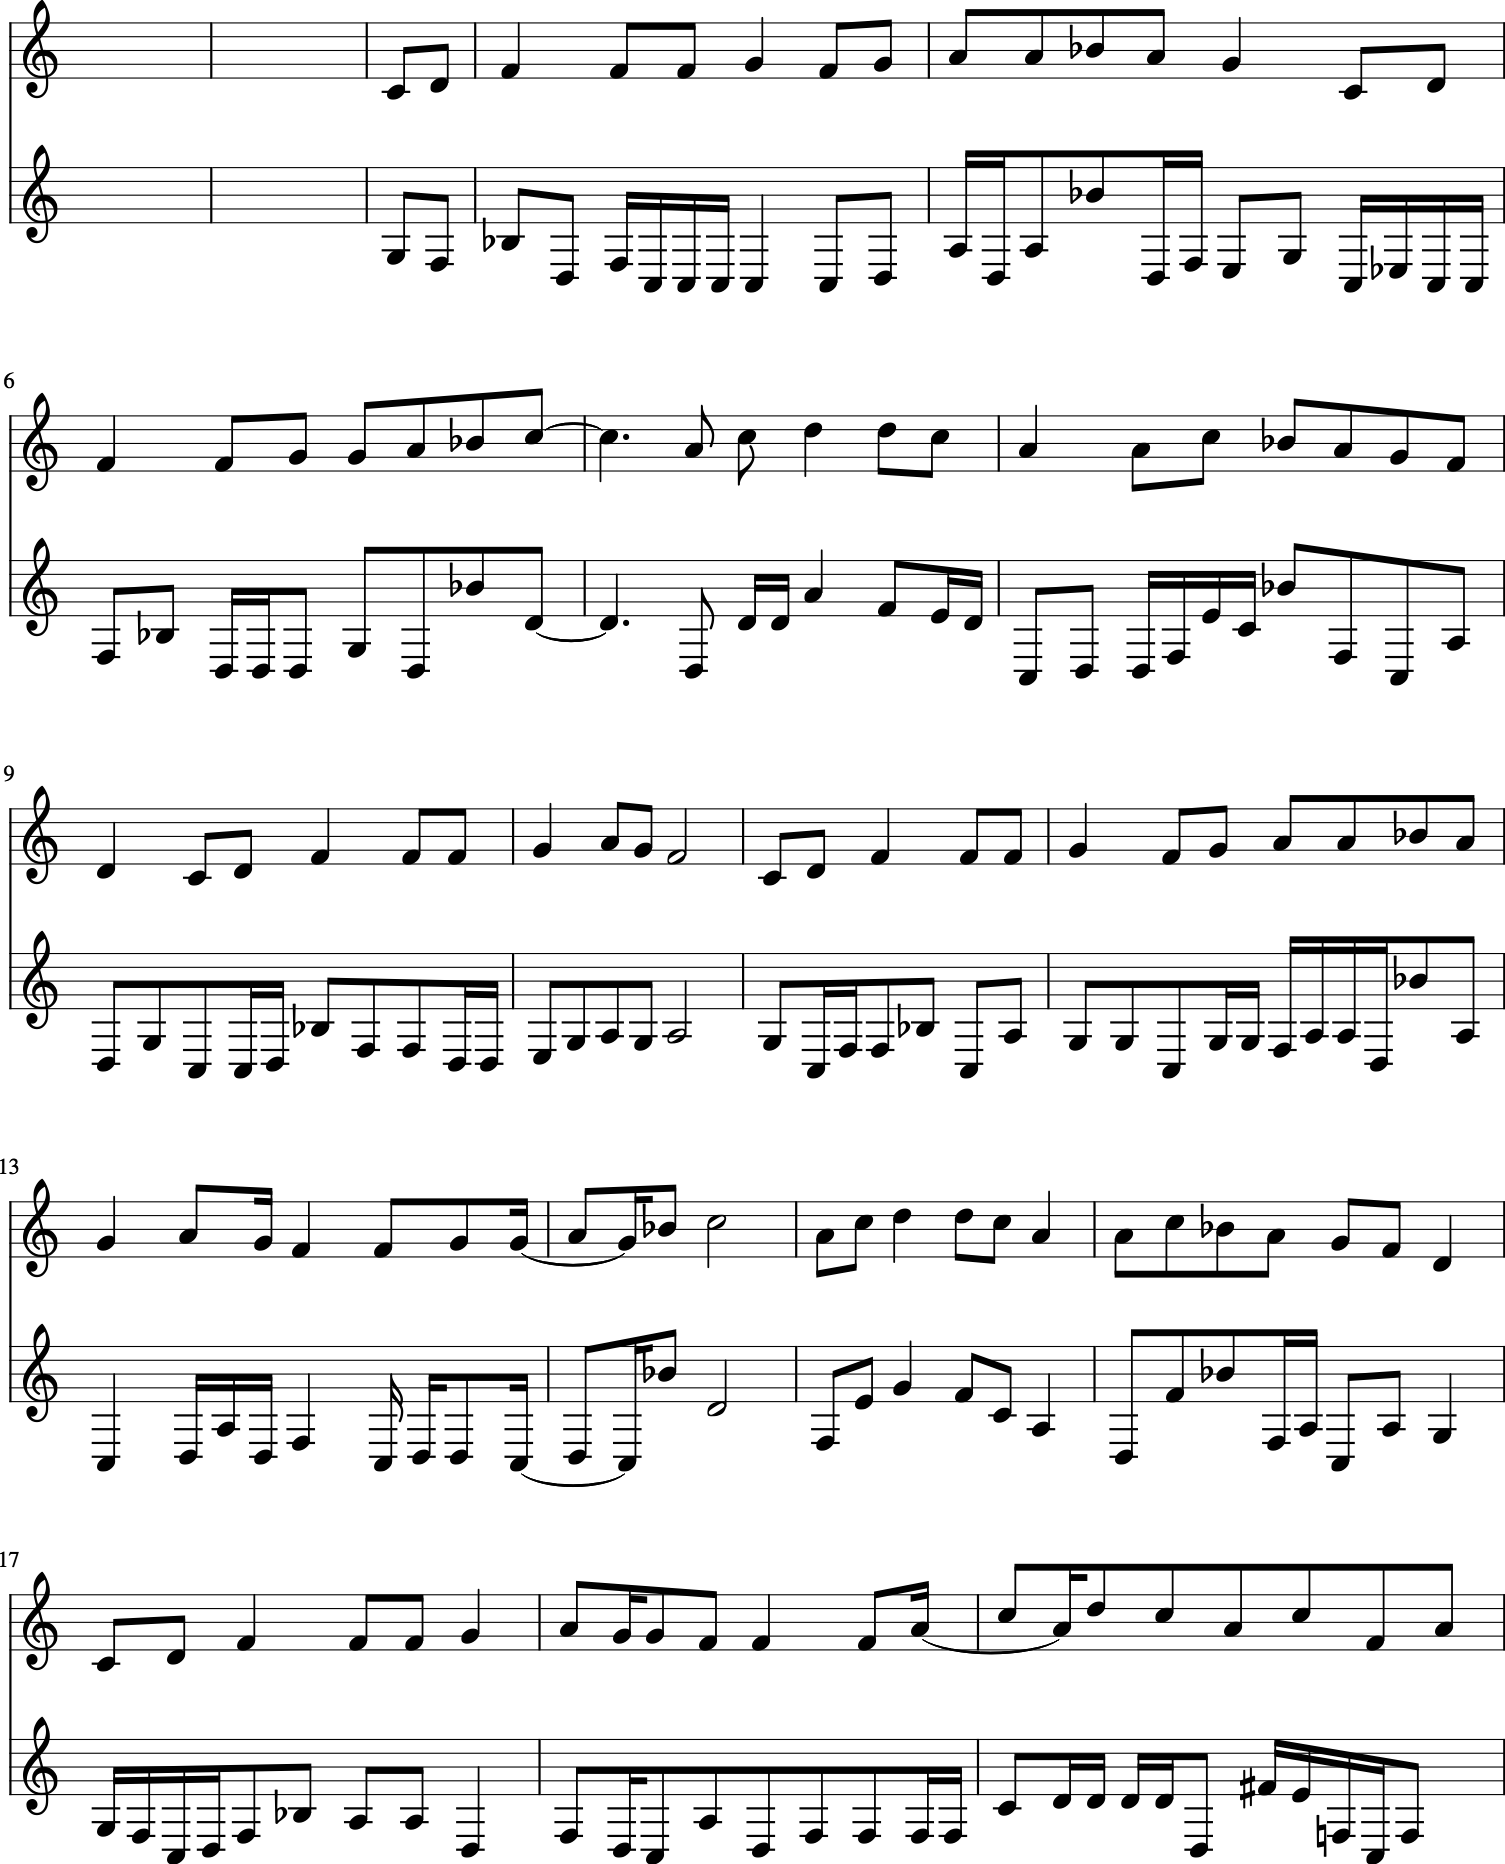

In [54]:
clef1 = clef.TrebleClef()
clef2 = clef.BassClef()
score = stream.Score([clef1, part_main, clef2, part_accom])
score.show()

In [56]:
score.show('midi')

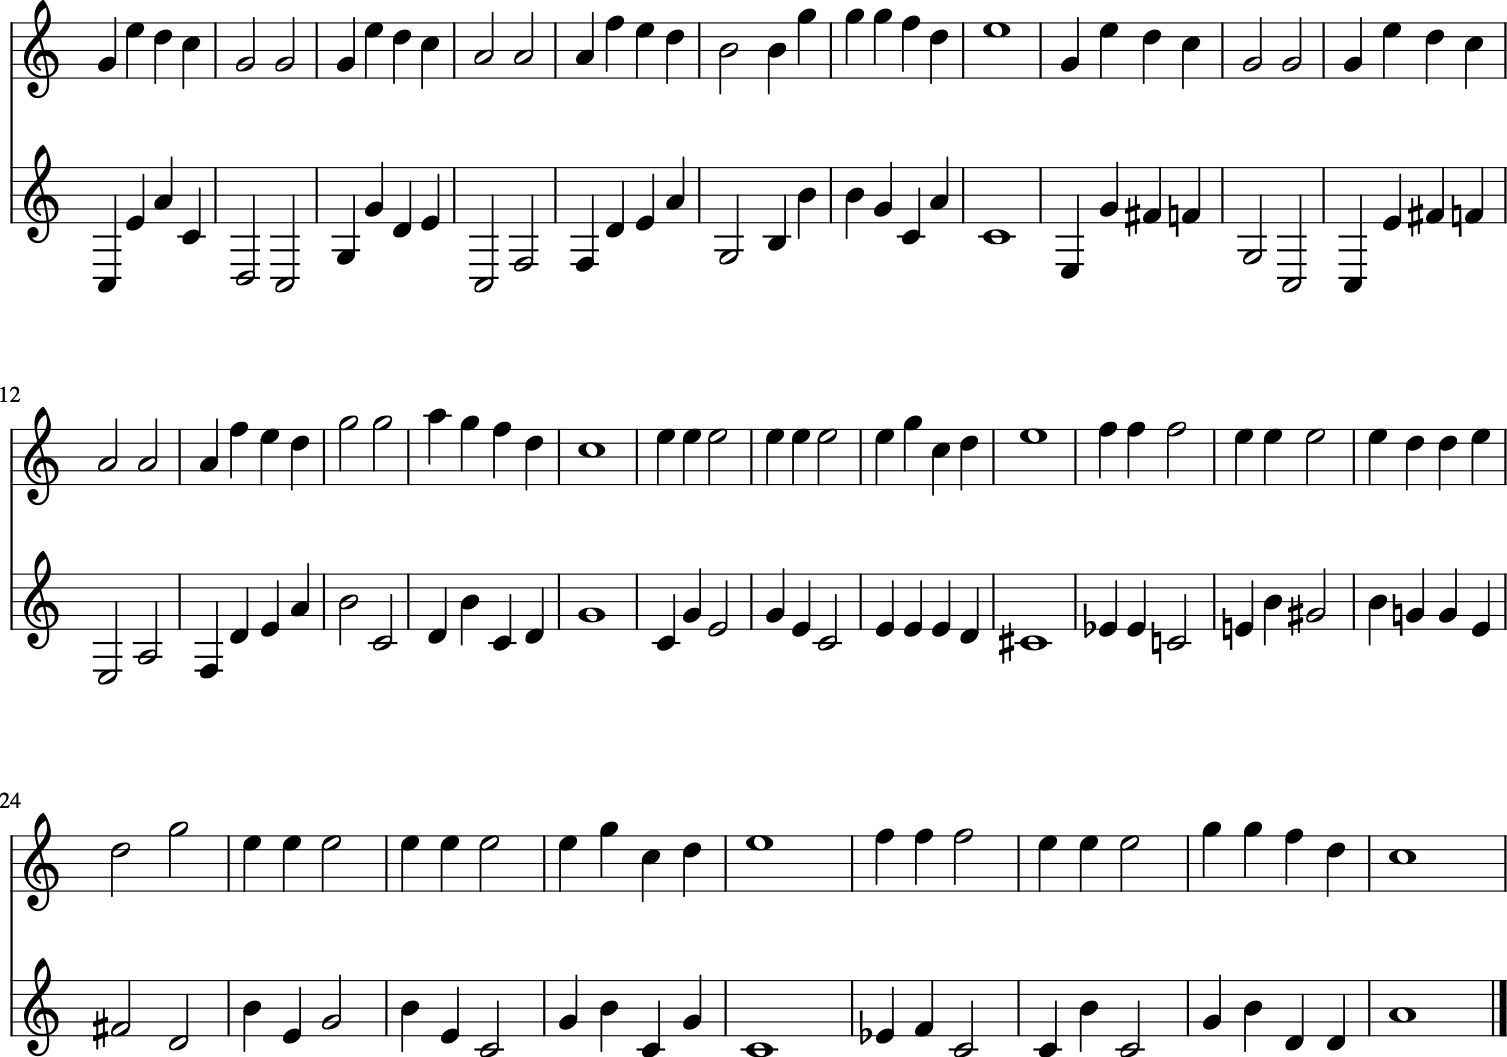

In [32]:
score.show()

In [57]:
score.write('midi',fp=r'partB_12_31.mid')

'partB_12_31.mid'

In [21]:
c = music21.converter.parse('/Users/lisalan/Desktop/AI_music/example.xml')
# c.show('musicxml.pdf')
c.show('midi')